In [69]:
%load_ext autoreload
%autoreload 2
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
RESULT_JSON = "/Users/law/repos/viper/results/ycsb/ycsb_all_revision.json"

In [71]:
import json

results_raw = json.loads(open(RESULT_JSON).read())
assert results_raw["context"]["library_build_type"] != "debug"
BENCHMARKS =  results_raw["benchmarks"]
# print(BENCHMARKS)

In [78]:
from collections import defaultdict
runs = defaultdict(list)

FIXTURES = [VIPER, PMEMKV, DASH, UTREE, CRL_STORE ]#HYBRID_FASTER]
BM_TYPES = ['5050_uniform', '1090_uniform', '5050_zipf', '1090_zipf']

RUNS = get_benchmarks(BENCHMARKS, FIXTURES, BM_TYPES)

# pprint(RUNS)

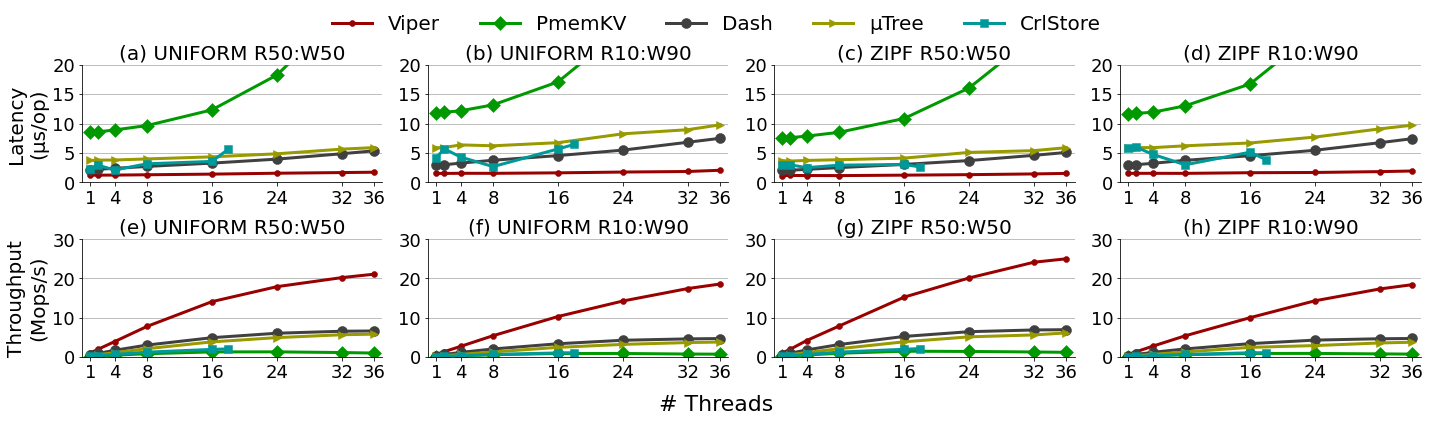

In [81]:
fig, (lat_axes, tp_axes) = plt.subplots(2, 4, figsize=(20, 5))
uniform_5050_ax, uniform_1090_ax, zipf_5050_ax, zipf_1090_ax = lat_axes
uniform_5050_ax_tp, uniform_1090_ax_tp, zipf_5050_ax_tp, zipf_1090_ax_tp = tp_axes

def get_bm_ax(bm_type):
    if bm_type == '5050_uniform': return (uniform_5050_ax, uniform_5050_ax_tp)
    if bm_type == '1090_uniform': return (uniform_1090_ax, uniform_1090_ax_tp)
    if bm_type == '5050_zipf': return (zipf_5050_ax, zipf_5050_ax_tp)
    if bm_type == '1090_zipf': return (zipf_1090_ax, zipf_1090_ax_tp)
    raise RuntimeError(f"Unknown bm_type {bm_type}")

num_threads = sorted({run['threads'] for run in list(RUNS.values())[0]})
SEC_IN_US = 1000000

for bm_type in BM_TYPES:
    (lt_ax, tp_ax) = get_bm_ax(bm_type)
#     lt_ax.set_xlabel("# Threads", fontsize=20)
#     tp_ax.set_xlabel("# Threads", fontsize=20)
    
    for (fixture, _) in FIXTURES:        
        lat_runs = [r for r in RUNS[(fixture, bm_type)] if f"{bm_type}_lat" in r['name']]
        tp_runs = [r for r in RUNS[(fixture, bm_type)] if f"{bm_type}_tp" in r['name']]
        
        tp = [run['items_per_second'] / MILLION for run in tp_runs]
        hdr_avg = [run['hdr_avg'] / 1000 for run in lat_runs]
        
        
#         print(f"{bm_type}: {tp} | {hdr_avg}")
#         hdr_99 = [run['hdr_avg'] / 1000 for run in RUNS[(fixture, bm_type)]]
        
        style = STYLES[fixture]
        x_vals = [1, 2, 4, 8, 16, 18] if fixture == CRL_STORE[0] and bm_type != 'get' else num_threads
        lt_ax.plot(x_vals, hdr_avg, marker=style.marker, ms=style.marker_size, 
                   color=style.color, markeredgewidth=0.5, lw=3)
        tp_ax.plot(x_vals, tp, marker=style.marker, ms=style.marker_size, 
                   color=style.color, markeredgewidth=0.5, lw=3)
        
#         ax.plot(num_threads, times, marker=style.marker, ms=style.marker_size, 
#                 color=style.color, markeredgewidth=0.5, lw=2)
#         ax.plot(num_threads, r, marker=style.marker, ms=style.marker_size, 
#                 color=style.color, markeredgewidth=0.5, lw=2)
#     lt_ax.set_yscale('log')
    for ax in [lt_ax, tp_ax]:
        ax.set_xticks([1, 4, 8, 16, 24, 32, 36])
        ax.set_xlim(0, 37)
        ax.grid(axis='y', which='major')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(18)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(18)

#     lt_ax.set_yscale('log')
    

uniform_5050_ax.set_ylabel("Latency\n(µs/op)", fontsize=20)
uniform_5050_ax.set_title(f"(a) UNIFORM R50:W50", fontsize=20)
uniform_1090_ax.set_title(f"(b) UNIFORM R10:W90", fontsize=20)
zipf_5050_ax.set_title(f"(c) ZIPF R50:W50",    fontsize=20)
zipf_1090_ax.set_title(f"(d) ZIPF R10:W90", fontsize=20)

uniform_5050_ax.set_ylim(0, 20)
uniform_1090_ax.set_ylim(0, 20)
zipf_5050_ax.set_ylim(0, 20)
zipf_1090_ax.set_ylim(0, 20)

uniform_5050_ax_tp.set_ylabel("Throughput\n(Mops/s)", fontsize=20)
uniform_5050_ax_tp.set_title(f"(e) UNIFORM R50:W50", fontsize=20)
uniform_1090_ax_tp.set_title(f"(f) UNIFORM R10:W90", fontsize=20)
zipf_5050_ax_tp.set_title(f"(g) ZIPF R50:W50",    fontsize=20)
zipf_1090_ax_tp.set_title(f"(h) ZIPF R10:W90", fontsize=20)

uniform_5050_ax_tp.set_ylim(0, 30)
uniform_1090_ax_tp.set_ylim(0, 30)
zipf_5050_ax_tp.set_ylim(0, 30)
zipf_1090_ax_tp.set_ylim(0, 30)

fig.text(0.5, -0.05, "# Threads", ha='center', fontsize=22)

fig.legend(loc='upper center', labels=[f[1] for f in FIXTURES], 
           bbox_to_anchor=(0.5, 1.1), ncol=6, frameon=False, fontsize=20)

for ax in [*tp_axes, *lat_axes]:
    hide_border(ax, show_left=True)
plt.tight_layout()
fig.savefig('charts/ycsb.pdf', bbox_inches='tight')
fig.savefig('charts/ycsb.svg', bbox_inches='tight')